# Построение и реализация модели оценки рыночного риска по портфелю

**Структура ноутбука:**
1. [Выгрузка данных портфеля, разбиение выборок](#first-bullet)
2. [Определение риск-факторов и модель динамики](#second-bullet)
3. [Оценка справедливой стоимости инструментов - реализация классов для применения PCA и линейной регрессии](#third-bullet)
4. [Оценка риска по портфелю - основная логика расчетов](#fourth-bullet)
5. [Количественная валидация](#fifth-bullet)

In [1]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

## 1. Выгрузка данных <a class="anchor" id="first-bullet"></a>
Состав анализируемого портфеля:
* **Облигации** (по 10 млн руб): ОФЗ 26218, ОФЗ 26207, ОФЗ 26212, ОФЗ 26211, ОФЗ 26209
* **Акции** (по 1 млн руб): Транспортная группа FESCO, Аптечная сеть 36,6, Распадская, Нижнекамскнефтехим, М.Видео, Белуга Групп, Фосагро, Сургутнефтегаз, Селигдар, ПИК
* **Валюта** (по 10 млн руб): доллар США, Швейцарский франк

In [2]:
# Обучение проводим включительно по эту дату
split_date = "2020-12-30"

In [3]:
interest_rates = ["cbr_g_curve"]
currencies = ["USD", "CHF"]
indexes = ["BRENT", "GOLD", "IMOEX", "RTSI"]
stocks = [
    "APTK",
    "BELU",
    "FESH",
    "MVID",
    "NKNCP",
    "PHOR",
    "PIKK",
    "RASP",
    "SELG",
    "SNGSP",
]
bonds = [
    "OFZ_26207",
    "OFZ_26209",
    "OFZ_26211",
    "OFZ_26212",
    "OFZ_26218",
]
instruments = stocks + bonds

In [4]:
def concat_data(files):
    df = []
    for file in files:
        df.append(pd.read_csv(file))
    dfs = df[0]
    for x in df[1:]:
        dfs = pd.merge(dfs, x, on=["Date"], how="outer")

    dfs = dfs[(dfs["Date"] >= "2016-01-01") & (dfs["Date"] < "2022-01-01")].copy()
    dfs.set_index("Date", inplace=True)
    dfs.sort_index(inplace=True)
    dfs.index = pd.to_datetime(dfs.index)
    # dfs.dropna(inplace=True)
    return dfs.copy()

In [5]:
path = "./data/{}.csv"
df_risk = [path.format(x) for x in interest_rates + currencies + indexes]
df_risk = concat_data(df_risk)

df_tools = [path.format(x) for x in instruments]
df_tools = concat_data(df_tools)

common_index = pd.merge(df_risk, df_tools, on=["Date"], how="outer").dropna().index
df_risk = df_risk.loc[common_index].copy()
df_tools = df_tools.loc[common_index].copy()

df = pd.merge(df_risk, df_tools, on=["Date"], how="outer")
features_risk = list(df_risk.columns)
features_tools = list(df_tools.columns) + currencies
print(len(df), len(df_risk), len(df_tools))

1109 1109 1109


Разбиение на train и test, взятие процентных приращений

In [6]:
train_df = df[df.index <= split_date].pct_change().dropna(axis=0)
test_df = df[df.index > split_date].pct_change().dropna(axis=0)
all_df = df.pct_change().dropna(axis=0)

Посмотрим на коррелированность акций

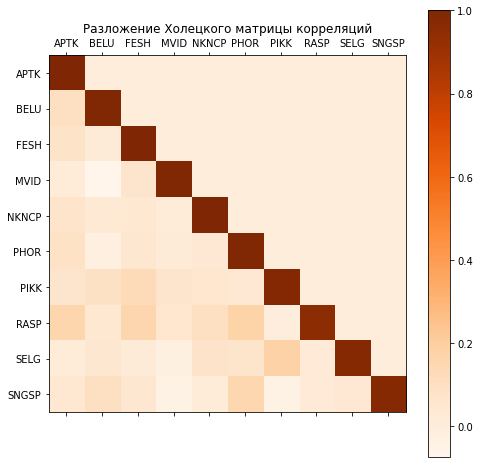

In [7]:
stocks_corr = np.linalg.cholesky(np.corrcoef(train_df[stocks], rowvar=False))
plt.figure(figsize=(8, 8))
plt.matshow(stocks_corr, cmap="Oranges", fignum=1)
plt.title("Разложение Холецкого матрицы корреляций")
plt.xticks(ticks=np.arange(len(stocks)), labels=stocks)
plt.yticks(ticks=np.arange(len(stocks)), labels=stocks)
plt.colorbar()
plt.show()

## 2. Модель динамики риск-факторов <a class="anchor" id="second-bullet"></a>

Выделим следующие риск-факторы для облигаций и валюты:
* процентные ставки **IR RUB** (процентный риск)
* курсы валют **USD, CHF** (валютный риск)
* цены товаров **BRENT** и драгоценных металлов **GOLD** (товарный риск)
* котировки индексов **IMOEX, RTSI** (фондовый риск)

Риск-факторы для акций:
* котировки акций (фондовый риск)

В качестве модели динамики будем использовать модель *Геометрического броуновского движения (GBM)*, которая позволяет моделировать динамику цен на финансовом рынке.

${S_{t}=S_{0}\exp \left(\left(\mu -{\frac {\sigma ^{2}}{2}}\right)t+\sigma W_{t}\right),}$

где $W_{t}$ - винеровский процесс, $\mu$ и $\sigma$ - параметры моделируемого риск-фактора, $S_{0}$ - начальное состояние риск-фактора.

Приращения случайного процесса вычисляются по следущей формуле:
${dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t}}$

При симуляции всех факторов единовременно соблюдается их скоррелированность в каждом сценарии (симуляции). Для этого реализованы симуляции скоррелированных приращений Винеровского процесса с использованием разложения Холецкого для матрицы корреляций.

In [8]:
def get_step_simulations(data, t, rounds=1000, random_state=42):
    """
    Симуляция процентного приращения риск-фактора на t шагов вперед
    """
    rnd = np.random.RandomState(random_state)
    if data.shape[1] > 1:
        corr_matrix = np.linalg.cholesky(np.corrcoef(data, rowvar=False))
    else:
        corr_matrix = np.array([[1]])
    rnd_vec = (
        corr_matrix
        @ np.cumsum(np.sqrt(1 / t) * rnd.normal(loc=0, scale=1, size=(data.shape[1], rounds, t)), axis=2)[:, :, -1]
    )
    # здесь вычисляется процентное приращение риск-фактора
    new_vals = np.exp((data.mean(axis=0) - data.std(axis=0) ** 2 / 2) / t + data.std(axis=0) * rnd_vec.T) - 1
    return new_vals

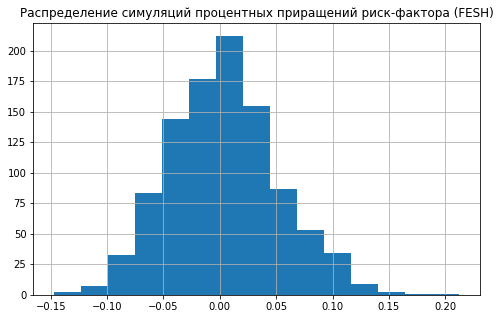

NormaltestResult(statistic=array([13.24561301]), pvalue=array([0.00132969]))


In [9]:
stock_sim = get_step_simulations(all_df[['FESH']].values[200 : 200 + 60], 1)
plt.figure(figsize=(8, 5))
plt.hist(stock_sim, bins=15)
plt.title('Распределение симуляций процентных приращений риск-фактора (FESH)')
plt.grid()
plt.show()
print(ss.normaltest(stock_sim))

## 3. Оценка справедливой стоимости инструментов <a class="anchor" id="third-bullet"></a>

С помощью классса `Model` реализован интерфейс обучения и применения PCA и линейной регрессии для перевода приращений PCA риск-факторов в приращения инструмента

Далее в классе `AutoModel` представлен подбор оптимального кол-ва PCA для каждого инструмента с помощью библиотеки `optuna`

In [9]:
import optuna
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.ERROR)


class Model:
    def __init__(self, n_components=None, pca_args=None, lr_args=None):
        self.pca_args = pca_args or {"random_state": 42}
        self.lr_args = lr_args or {}
        self.n_components = n_components
        self.pca = n_components and PCA(n_components, **self.pca_args)
        self.lr = LinearRegression(**self.lr_args)
        self.cols = None

    def get_values(self, x):
        if self.cols and isinstance(x, pd.DataFrame):
            x = x[self.cols]
        if isinstance(x, (pd.DataFrame, pd.Series)):
            return x.values
        return x

    def fit(self, data, target):
        if isinstance(data, pd.DataFrame):
            self.cols = list(data.columns)
        data = self.get_values(data)
        target = self.get_values(target)
        if self.pca:
            data = self.pca.fit_transform(data)
        self.lr.fit(data, target)
        return self

    def predict_pca(self, data):
        data = self.get_values(data)
        if self.pca:
            return self.pca.transform(data)
        return data

    def predict_lr(self, data):
        return self.lr.predict(data)

    def predict(self, data):
        data = self.predict_pca(data)
        return self.predict_lr(data)

    def __repr__(self):
        return "{}({}, {})".format(self.__class__.__name__, self.pca, self.lr)


class AutoModel:
    def __init__(self, cv_splits=5, n_trials=10, max_components=10, metric=None):
        self.splitter = TimeSeriesSplit(cv_splits)
        self.study = optuna.study.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
        self.metric = metric or r2_score
        self.n_trials = n_trials
        self.max_components = max_components

    def fit(self, data, target):
        data_ = data
        target_ = target
        if isinstance(data, (pd.DataFrame, pd.Series)):
            data = data.values
        if isinstance(target, (pd.DataFrame, pd.Series)):
            target = target.values

        def objective(trial):
            components = trial.suggest_int("n_components", 2, min([self.max_components, *data.shape]))
            for t in trial.study.trials:
                if t.state != optuna.trial.TrialState.COMPLETE:
                    continue
                if t.params == trial.params:
                    raise optuna.exceptions.TrialPruned("Duplicate parameter set")

            scores = []
            for train_idx, test_idx in self.splitter.split(data):
                model = Model(components)
                model.fit(data[train_idx], target[train_idx])
                proba = model.predict(data[test_idx])
                score = self.metric(target[test_idx], proba)
                scores.append(score)
            return np.mean(scores)

        self.study.optimize(objective, self.n_trials)
        return Model(**self.study.best_params).fit(data_, target_)

Изменения акций плохо объясняются риск-факторами для облигаций и валюты

In [10]:
results = []
instrument_models = {}

for f in features_tools:
    m = AutoModel().fit(train_df[features_risk], train_df[f])
    score = m.predict(train_df)
    score_test = m.predict(test_df)
    results.append(
        {
            "tool": f,
            "n_components": m.n_components,
            "r2_train": r2_score(train_df[f], score),
            "r2_test": r2_score(test_df[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results.head(10)

,tool,n_components,r2_train,r2_test
0,APTK,5,0.030125,-0.045158
1,BELU,2,0.011270,-0.007362
2,FESH,5,0.093600,-0.058240
3,MVID,2,0.010595,-0.026952
4,NKNCP,5,0.050597,0.043962
5,PHOR,9,0.140284,0.006302
6,PIKK,2,0.029648,0.000659
7,RASP,5,0.162794,0.006060
8,SELG,2,0.032428,0.009306
9,SNGSP,9,0.160947,-0.091917


In [11]:
results = []
instrument_models = {}

for f in features_tools:
    if f in stocks:
        m = Model().fit(train_df[[f]], train_df[f])
    else:
        m = AutoModel().fit(train_df[features_risk], train_df[f])
    score = m.predict(train_df)
    score_test = m.predict(test_df)
    results.append(
        {
            "tool": f,
            "n_components": m.n_components,
            "r2_train": r2_score(train_df[f], score),
            "r2_test": r2_score(test_df[f], score_test),
        }
    )
    instrument_models[f] = m
results = pd.DataFrame(results)
results.tail(7)

,tool,n_components,r2_train,r2_test
10,OFZ_26207,9.0,0.852326,0.710332
11,OFZ_26209,5.0,0.513229,-1.806175
12,OFZ_26211,5.0,0.561310,-0.499484
13,OFZ_26212,8.0,0.868009,0.719628
14,OFZ_26218,10.0,0.880211,0.822877
15,USD,10.0,0.953873,0.925201
16,CHF,10.0,0.948729,0.908570


## 4. Оценка риска по портфелю <a class="anchor" id="fourth-bullet"></a>

В классе `Portfolio` реализован портфель из инструментов `Intrument`, позволяющий ребалансировать долю инструментов и расчитывать стоимость порфеля:

$$ \text{portfolio_cost} = \sum_i \text{count}_i \text{price}_i $$

В классе `PortfolioSimulation` реализована основная логика расчетов:
1. Для каждого инструмента (облигации и валюта) подбираем оптимальное кол-во PCA риск-факторов по обучающей выборке и обучаем модель линейной ререссии переводить изменения PCA в изменение иструмента
2. Симулируем коррелированные приращения риск-факторов
3. От симуляций риск-факторов переходим к PCA и с помощью модели линейной регрессии получаем соответствующие изменения инструмента (для облигаций и валюты)
4. По изменениям инструменов определяем изменение стоимости порфеля
5. Оцениваем меры риска по порфелю на каждый день (Value-at-Risk на уровне 99% и Expected Shortfall на уровне 97.5%)

In [12]:
import copy


class Instrument:
    def __init__(self, name, count, price):
        self.name = name
        self.cnt = count
        self.price = price

    @property
    def cost(self):
        return self.price * self.cnt

    def __repr__(self):
        return "{}({} x {})".format(self.name, self.cnt, self.price)


class Portfolio:
    def __init__(self, tools_with_money, init_prices):
        total = sum(tools_with_money.values())
        self.tools_target = {k: v / total for k, v in tools_with_money.items()}
        self.tools = {
            k: Instrument(k, tools_with_money[k] / init_prices[k], init_prices[k]) for k, v in self.tools_target.items()
        }

    @property
    def cost(self):
        return sum([x.cost for x in self.tools.values()])

    def _tool_rate(self):
        total_cost = self.cost
        return {k: v.cost / total_cost for k, v in self.tools.items()}

    def __getitem__(self, k):
        return self.tools[k]

    def rebalancing(self, new_prices):
        old_cost = self.cost
        old_prices = {k: self[k].price for k in self.tools}
        for k, p in new_prices.items():
            self[k].price = p
        new_cost = self.cost
        for k in self.tools:
            self[k].cnt *= new_cost / old_cost * old_prices[k] / new_prices[k]

        for k, v in self._tool_rate().items():
            assert np.abs(v - self.tools_target[k]) < 0.00001

    def new_cost(self, new_prices):
        new_cost = sum([v.cnt * new_prices[k] for k, v in self.tools.items()])
        return new_cost

    def copy(self):
        return copy.deepcopy(self)

**Функции оценки качества**

In [13]:
def semaphore(p):
    if p > 0.05:
        return "green"
    elif p > 0.0001:
        return "yellow"
    else:
        return "red"


def norm_percenile(x, level):
    return np.mean(x) + ss.norm.ppf(level) * np.std(x)

In [14]:
class PortfolioSimulation:
    def __init__(self, init_tools, window_size, t):
        features_tools = sorted(list(init_tools.keys()))
        p = Portfolio(init_tools, df.iloc[0][features_tools].to_dict())
        portfolio_prices = []
        for i, row in tqdm(df.iterrows(), total=len(df)):
            p.rebalancing(row[features_tools].to_dict())
            portfolio_prices.append(
                {
                    "date": i,
                    "price": p.cost,
                }
            )
        self.portfolio_prices = pd.DataFrame(portfolio_prices)
        self.portfolio_prices["price_change"] = self.portfolio_prices["price"].pct_change()

        instrument_simulations = [None] * len(features_tools)
        # Получаем симуляции для не-стоков
        for fi, f in tqdm(enumerate(features_tools), total=len(features_tools)):
            if f in stocks:
                continue
            m = instrument_models[f]
            pca_df = m.predict_pca(all_df)
            simulations = []
            for i in range(len(pca_df) - window_size - t):
                pca_sim = get_step_simulations(pca_df[i : i + window_size], t)
                simulations.append(m.predict_lr(pca_sim))
            instrument_simulations[fi] = simulations
        # Получаем симуляции для стоков
        if any([x is None for x in instrument_simulations]):
            stock_df = all_df[[f for f in features_tools if f in stocks]].values
            simulations = []
            for i in range(len(stock_df) - window_size - t):
                stock_sim = get_step_simulations(stock_df[i : i + window_size], t)
                simulations.append(stock_sim)
            simulations = np.array(simulations)
            stock_i = 0
            for fi, f in enumerate(features_tools):
                if f in stocks:
                    instrument_simulations[fi] = simulations[:, :, stock_i]
                    stock_i += 1

        assert all([x is not None for x in instrument_simulations])
        instrument_simulations = np.array(instrument_simulations)

        portfolio_prices_simulations = []
        df_ = df.iloc[window_size + t + 1 :].copy()
        p = Portfolio(init_tools, df_.iloc[0].to_dict())
        for j, (i, row) in tqdm(enumerate(df_.iterrows()), total=len(df_)):
            p.rebalancing(row[features_tools])
            p_sim = []
            p_init = p.cost
            # симуляции по всем инструментам за конкретный день
            new_prices = np.multiply(instrument_simulations[:, j, :].T, row[features_tools].values)  # N, tools
            new_prices = row[features_tools].values + new_prices
            for sim in new_prices:
                p_sim.append(p.new_cost({k: v for k, v in zip(features_tools, sim)}) / p_init - 1)
            portfolio_prices_simulations.append(
                {
                    "date": i,
                    "price_change": p_sim,
                }
            )

        self.portfolio_prices_simulations = pd.DataFrame(portfolio_prices_simulations)

        self.portfolio_prices_simulations["var_99"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -norm_percenile(x, 0.01)
        )

        self.portfolio_prices_simulations["es_97,5"] = -self.portfolio_prices_simulations["price_change"].map(
            lambda x: -(np.array(x)[np.array(x) < norm_percenile(x, 0.025)]).mean()
        )

        self.returns = (
            self.portfolio_prices.dropna(axis=0).iloc[window_size + t :]["price_change"].reset_index(drop=True)
        )

    def plot_dynamics(self):
        self.portfolio_prices.plot(x="date", y="price", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика стоимости портфеля")
        plt.show()

        self.portfolio_prices.dropna(axis=0).plot(x="date", y="price_change", figsize=(16, 6))
        plt.grid()
        plt.title("Динамика изменений стоимости портфеля")
        plt.show()

    def calc_test(self, risk, risk_name, risk_color="r*", alpha=0.99):
        hits = self.returns < self.portfolio_prices_simulations[risk]
        hit_times = hits.index[hits]
        print("Риск-фактор:", risk_name)
        print("Кол-во пробоев:", hits.sum())
        print("Доля пробоев:", np.round(hits.sum() / hits.size, 4))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="two-sided")
        print("Двухсторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        p_val = ss.binom_test(hits.sum(), hits.size, 1 - alpha, alternative="greater")
        print("Односторонняя гипотеза:", np.round(p_val, 4))
        print("Светофор за тест:", semaphore(p_val))

        plt.figure(figsize=(15, 4), facecolor="w")
        idx = self.portfolio_prices_simulations["date"]
        plt.plot(idx, self.returns)
        plt.plot(idx, self.portfolio_prices_simulations[risk], c="r", alpha=0.4, label=risk_name)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
        plt.axvline(pd.to_datetime(split_date), c="tab:orange", linestyle=":", label="train-test split")
        plt.plot(idx[hit_times], self.returns[hit_times], risk_color)
        plt.title("Динамика изменений стоимости портфеля, {}".format(risk_name))
        plt.ylabel("Процентное изменение")
        plt.grid()
        plt.legend()
        plt.show()

## 5. Количественная валидация <a class="anchor" id="fifth-bullet"></a>

### 5.1 Полный портфель 1 день

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

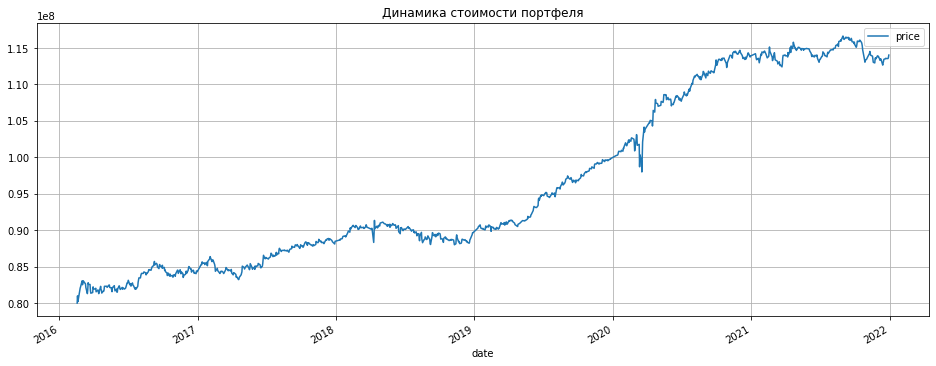

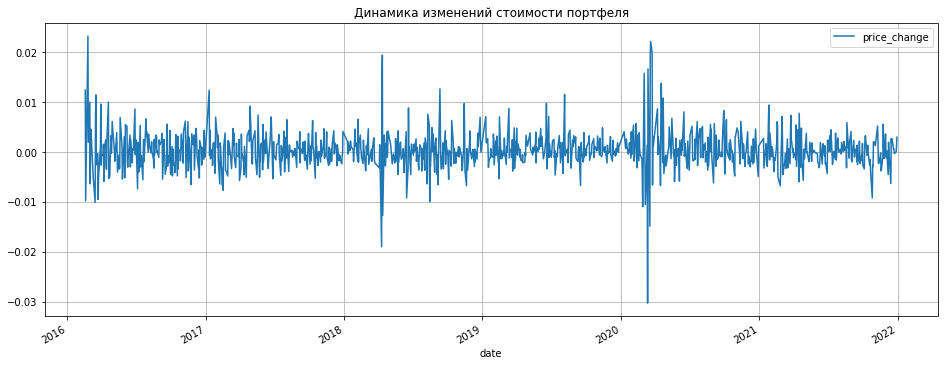

Риск-фактор: VAR 99
Кол-во пробоев: 14
Доля пробоев: 0.0134
Двухсторонняя гипотеза: 0.2731
Светофор за тест: green
Односторонняя гипотеза: 0.1711
Светофор за тест: green


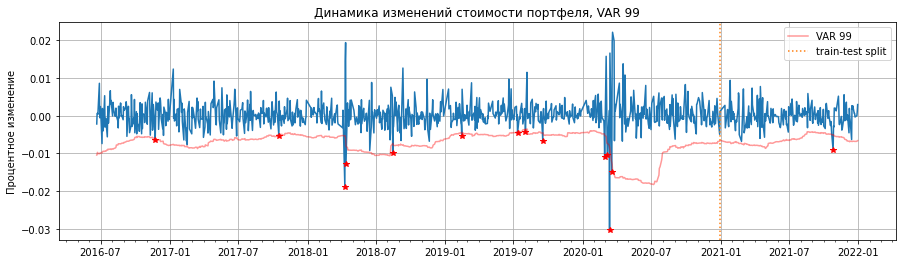

Риск-фактор: ES 97,5
Кол-во пробоев: 15
Доля пробоев: 0.0143
Двухсторонняя гипотеза: 0.1596
Светофор за тест: green
Односторонняя гипотеза: 0.1091
Светофор за тест: green


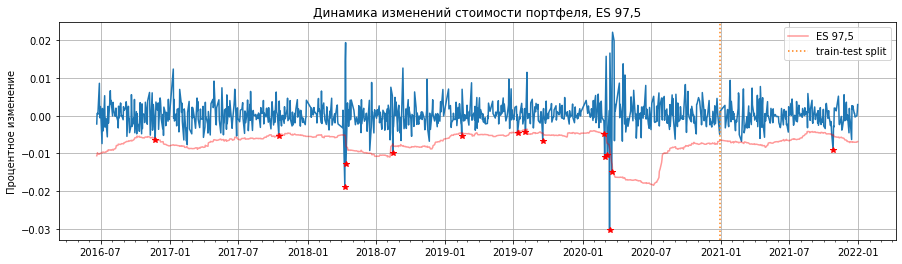

In [15]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.2 Полный портфель 10 дней

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

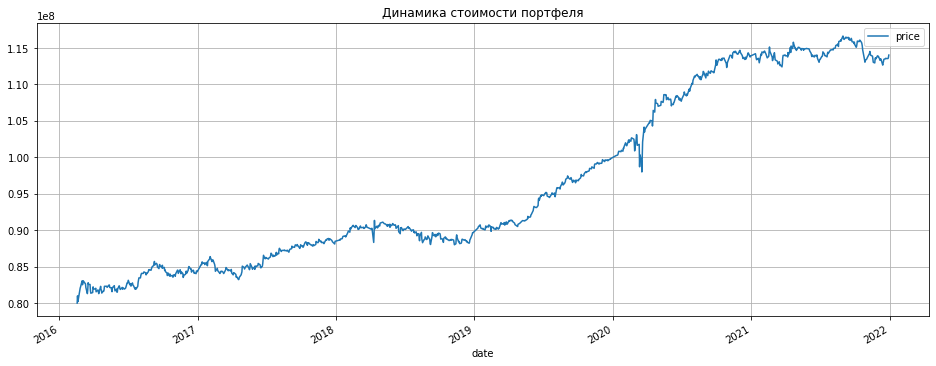

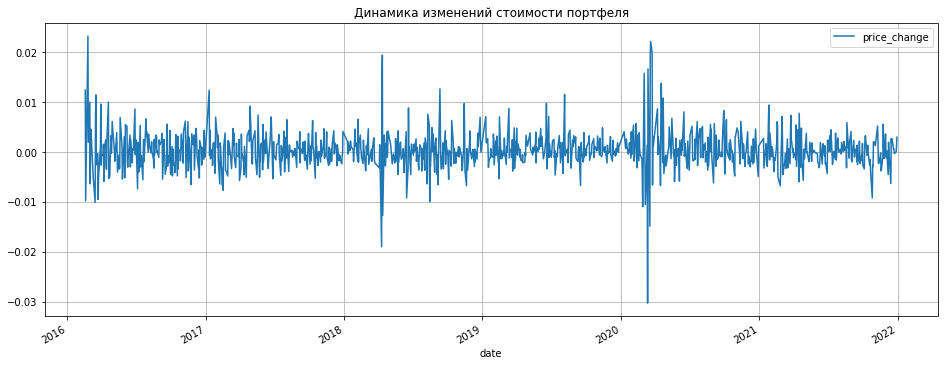

Риск-фактор: VAR 99
Кол-во пробоев: 15
Доля пробоев: 0.0145
Двухсторонняя гипотеза: 0.1568
Светофор за тест: green
Односторонняя гипотеза: 0.1037
Светофор за тест: green


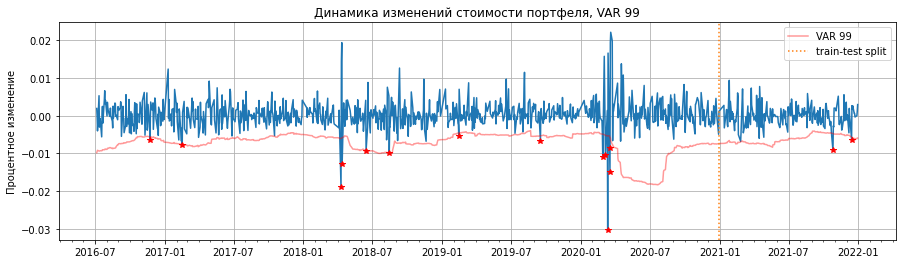

Риск-фактор: ES 97,5
Кол-во пробоев: 14
Доля пробоев: 0.0135
Двухсторонняя гипотеза: 0.2705
Светофор за тест: green
Односторонняя гипотеза: 0.1637
Светофор за тест: green


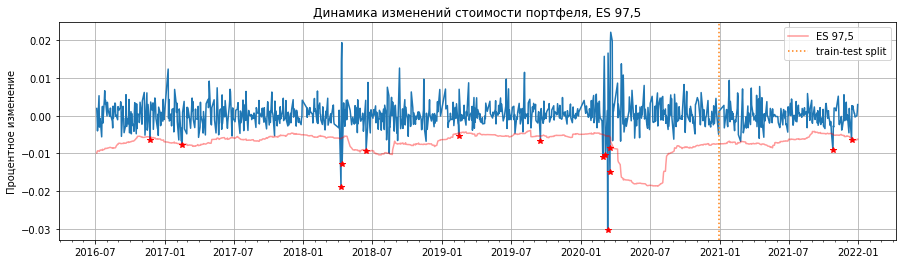

In [16]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.3 Портфель акций 1 день

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

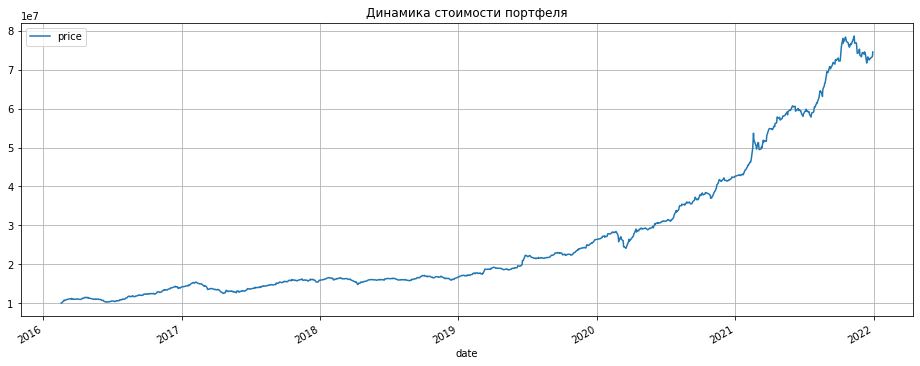

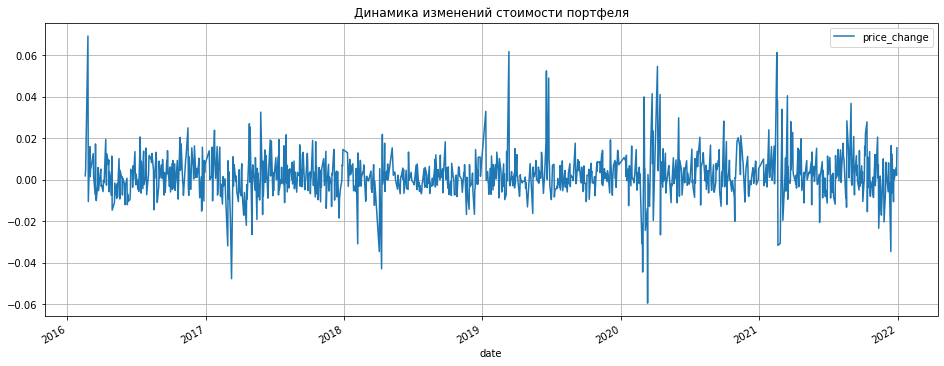

Риск-фактор: VAR 99
Кол-во пробоев: 21
Доля пробоев: 0.0201
Двухсторонняя гипотеза: 0.0029
Светофор за тест: yellow
Односторонняя гипотеза: 0.0026
Светофор за тест: yellow


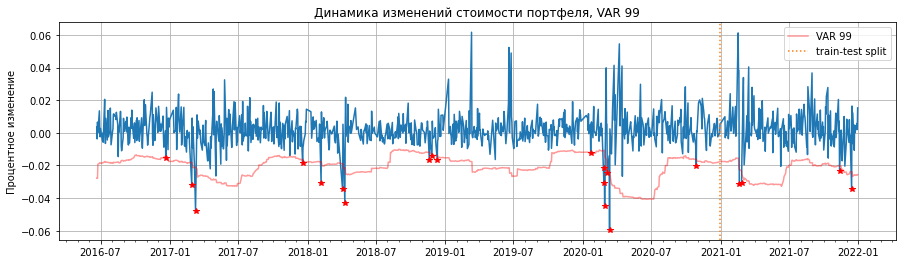

Риск-фактор: ES 97,5
Кол-во пробоев: 21
Доля пробоев: 0.0201
Двухсторонняя гипотеза: 0.0029
Светофор за тест: yellow
Односторонняя гипотеза: 0.0026
Светофор за тест: yellow


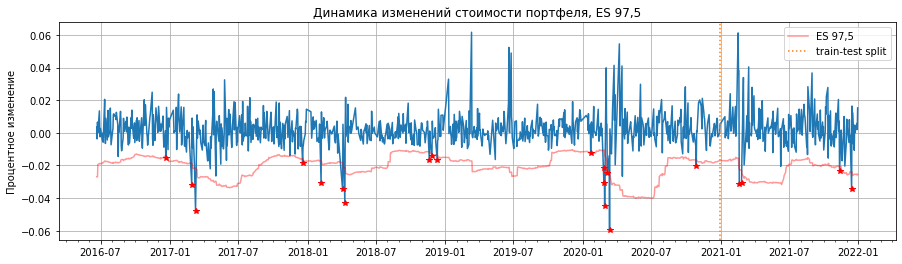

In [17]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.4 Портфель акций 10 дней

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

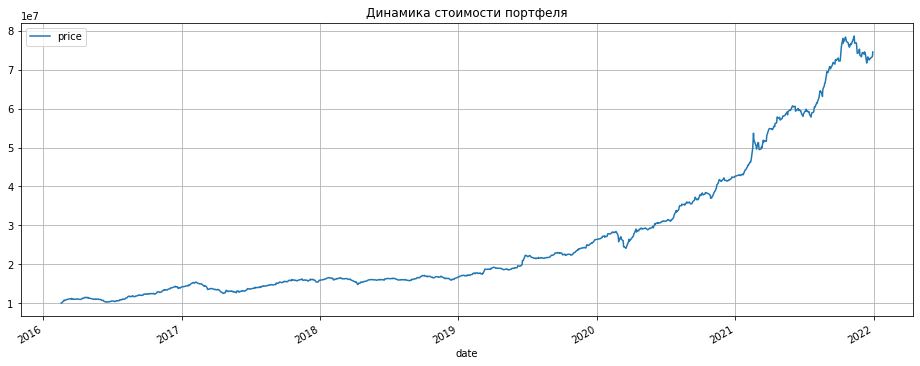

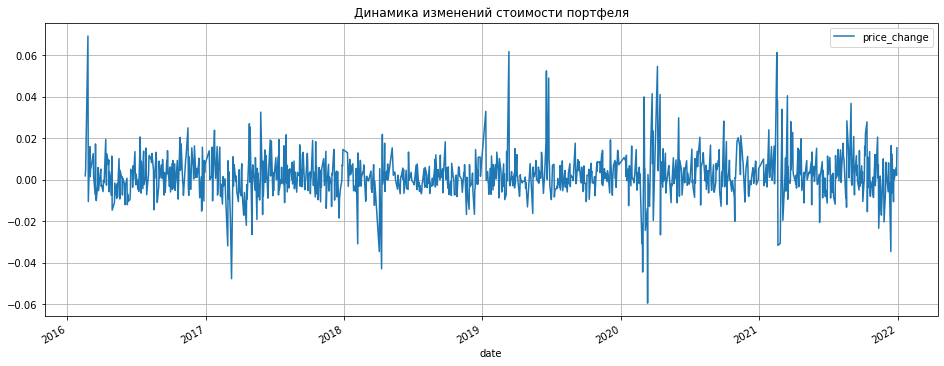

Риск-фактор: VAR 99
Кол-во пробоев: 19
Доля пробоев: 0.0183
Двухсторонняя гипотеза: 0.0119
Светофор за тест: yellow
Односторонняя гипотеза: 0.01
Светофор за тест: yellow


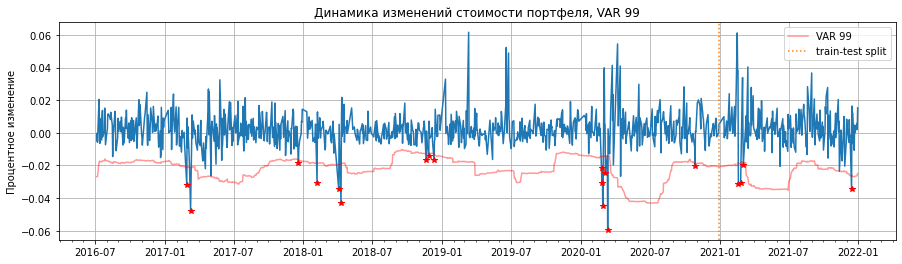

Риск-фактор: ES 97,5
Кол-во пробоев: 20
Доля пробоев: 0.0193
Двухсторонняя гипотеза: 0.0069
Светофор за тест: yellow
Односторонняя гипотеза: 0.0049
Светофор за тест: yellow


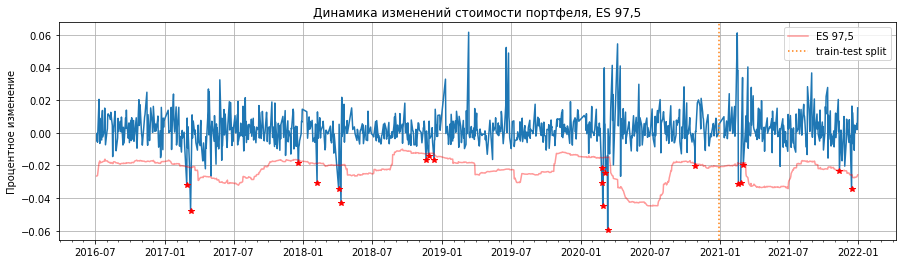

In [18]:
init_tools = {
    "APTK": 1_000_000,
    "BELU": 1_000_000,
    "FESH": 1_000_000,
    "MVID": 1_000_000,
    "NKNCP": 1_000_000,
    "PHOR": 1_000_000,
    "PIKK": 1_000_000,
    "RASP": 1_000_000,
    "SELG": 1_000_000,
    "SNGSP": 1_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.5 Портфель облигаций 1 день

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

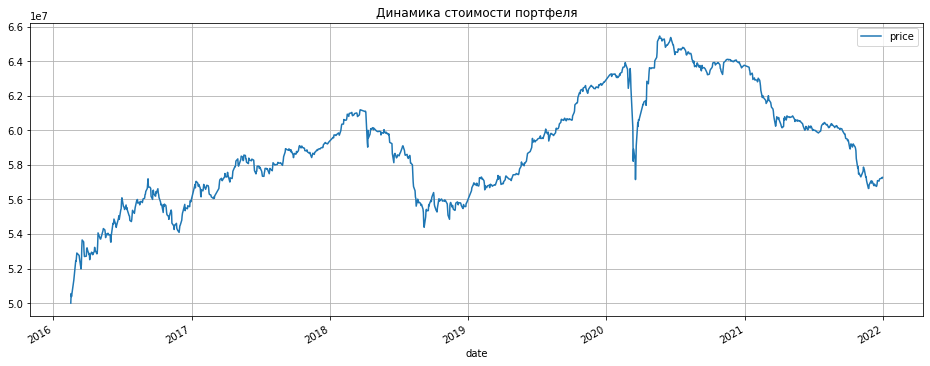

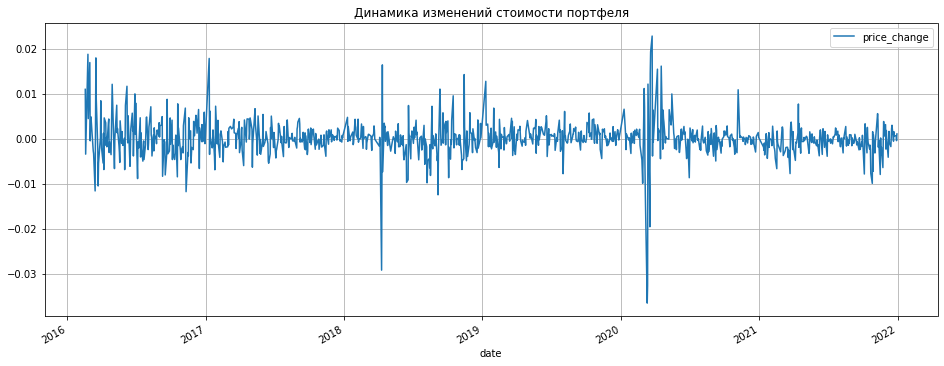

Риск-фактор: VAR 99
Кол-во пробоев: 20
Доля пробоев: 0.0248
Двухсторонняя гипотеза: 0.0003
Светофор за тест: yellow
Односторонняя гипотеза: 0.0003
Светофор за тест: yellow


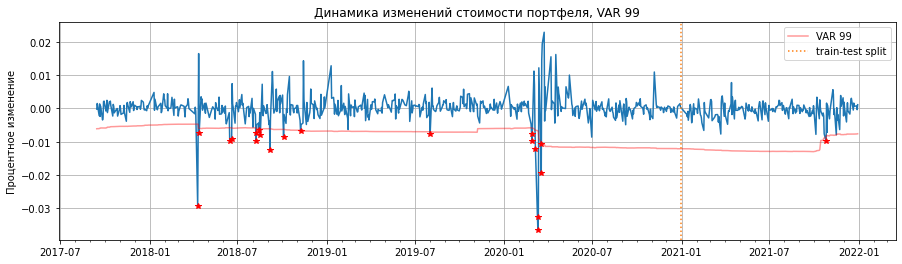

Риск-фактор: ES 97,5
Кол-во пробоев: 19
Доля пробоев: 0.0235
Двухсторонняя гипотеза: 0.001
Светофор за тест: yellow
Односторонняя гипотеза: 0.0007
Светофор за тест: yellow


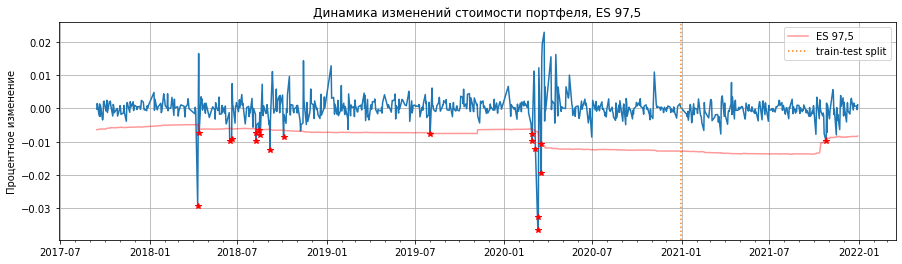

In [19]:
init_tools = {
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 300, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.6 Портфель облигаций 10 дней

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/798 [00:00<?, ?it/s]

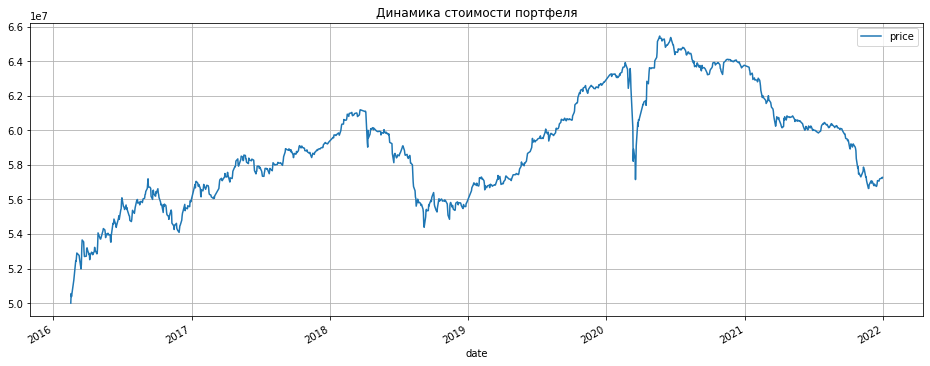

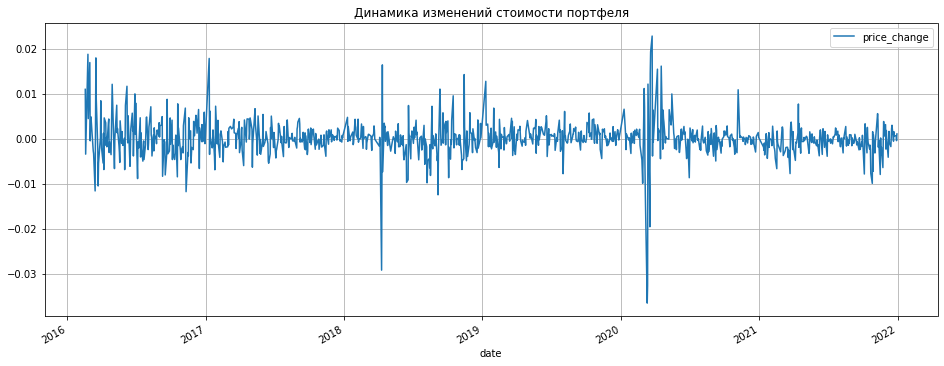

Риск-фактор: VAR 99
Кол-во пробоев: 20
Доля пробоев: 0.0251
Двухсторонняя гипотеза: 0.0002
Светофор за тест: yellow
Односторонняя гипотеза: 0.0002
Светофор за тест: yellow


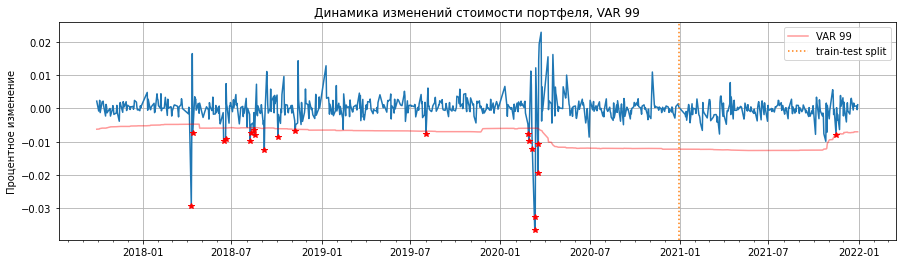

Риск-фактор: ES 97,5
Кол-во пробоев: 20
Доля пробоев: 0.0251
Двухсторонняя гипотеза: 0.0002
Светофор за тест: yellow
Односторонняя гипотеза: 0.0002
Светофор за тест: yellow


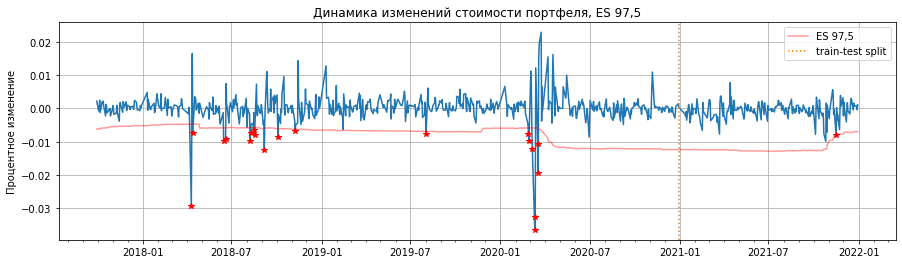

In [20]:
init_tools = {
    "OFZ_26207": 10_000_000,
    "OFZ_26209": 10_000_000,
    "OFZ_26211": 10_000_000,
    "OFZ_26212": 10_000_000,
    "OFZ_26218": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 300, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.7 Валютный портфель 1 день

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1047 [00:00<?, ?it/s]

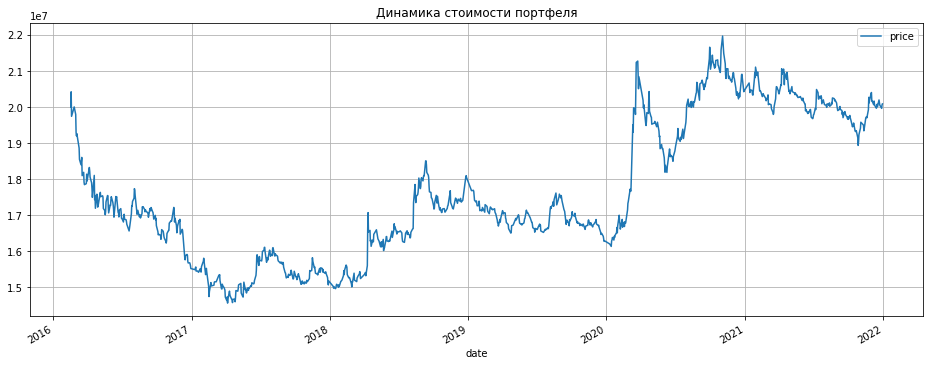

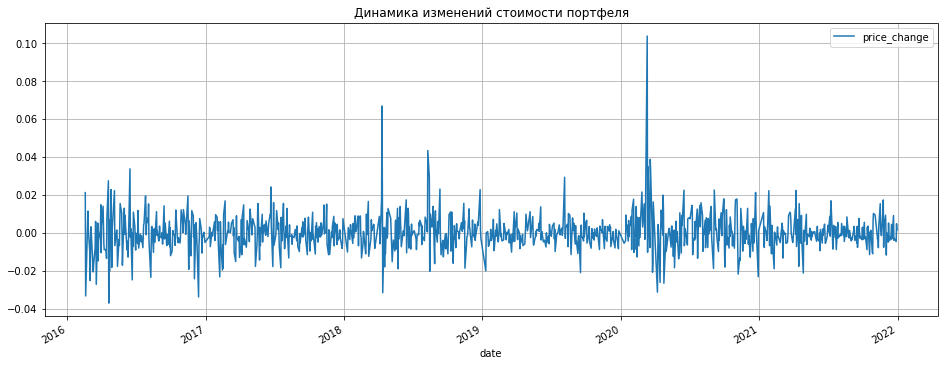

Риск-фактор: VAR 99
Кол-во пробоев: 13
Доля пробоев: 0.0124
Двухсторонняя гипотеза: 0.4336
Светофор за тест: green
Односторонняя гипотеза: 0.2542
Светофор за тест: green


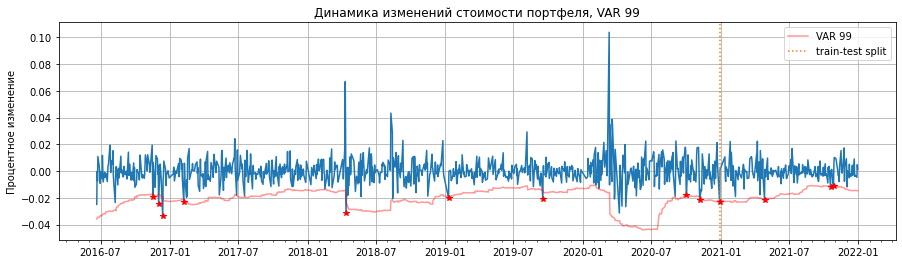

Риск-фактор: ES 97,5
Кол-во пробоев: 15
Доля пробоев: 0.0143
Двухсторонняя гипотеза: 0.1596
Светофор за тест: green
Односторонняя гипотеза: 0.1091
Светофор за тест: green


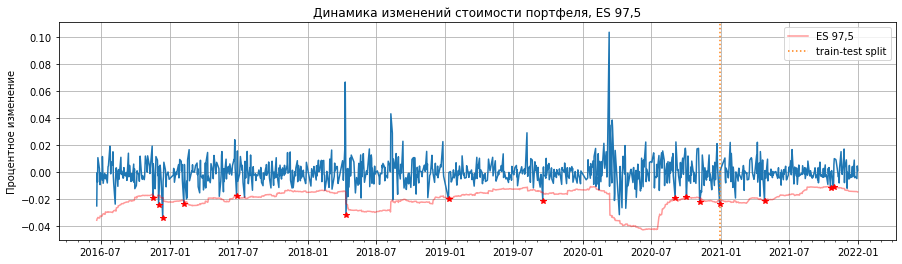

In [21]:
init_tools = {
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 1)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### 5.7 Валютный портфель 10 дней

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

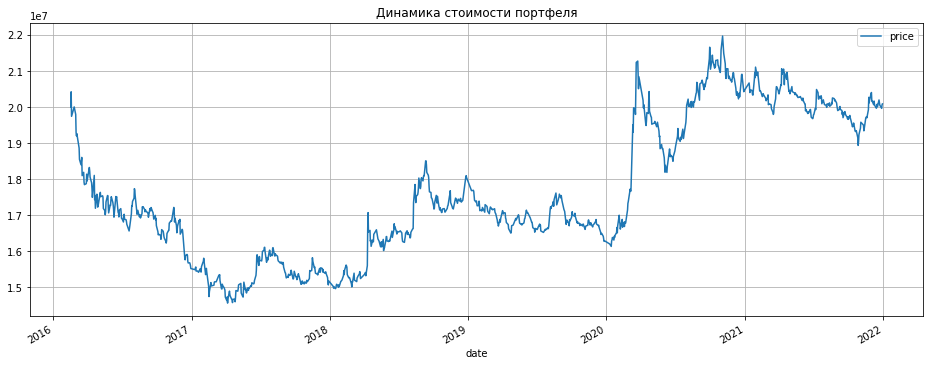

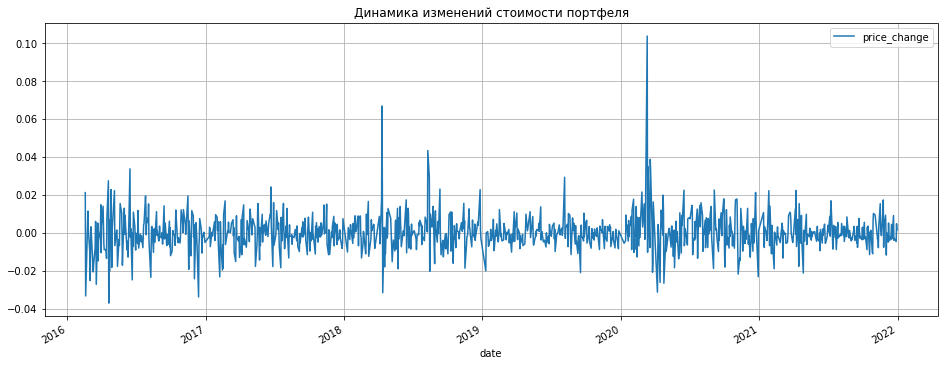

Риск-фактор: VAR 99
Кол-во пробоев: 16
Доля пробоев: 0.0154
Двухсторонняя гипотеза: 0.0846
Светофор за тест: green
Односторонняя гипотеза: 0.0623
Светофор за тест: green


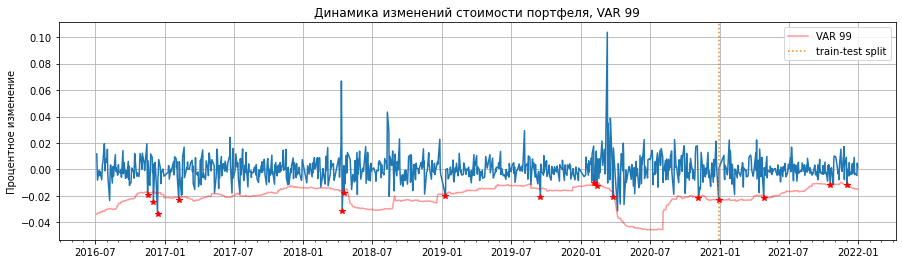

Риск-фактор: ES 97,5
Кол-во пробоев: 15
Доля пробоев: 0.0145
Двухсторонняя гипотеза: 0.1568
Светофор за тест: green
Односторонняя гипотеза: 0.1037
Светофор за тест: green


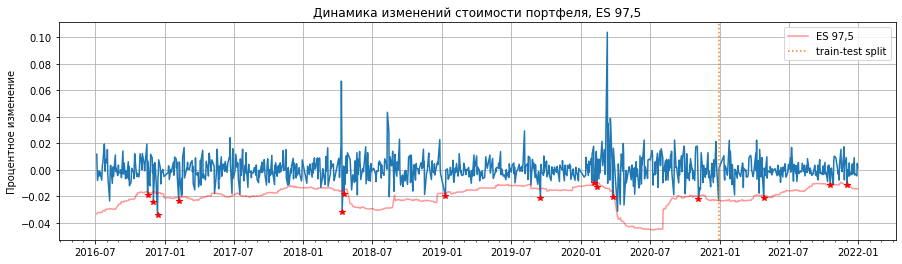

In [22]:
init_tools = {
    "USD": 10_000_000,
    "CHF": 10_000_000,
}
ps = PortfolioSimulation(init_tools, 60, 10)
ps.plot_dynamics()

ps.calc_test("var_99", "VAR 99", "r*", 0.99)
ps.calc_test("es_97,5", "ES 97,5", "r*", 0.99)

### Выводы

По результатам количественной валидации можно сказать, что модель может использоваться для оценки рыночного риска по портфелю. Модель хорошо показывает себя на полном портфеле и портфеле валюты, однако для портфеля акций и облигаций есть потенциал для улучшения

Модель хороша для валютного портфеля, поскольку на горизонте наблюдения не было значительных падений (только заметные скачки), в то время как облигации претерпевали сильные падения. Для акций, как для очень волатильного инструмента, модель допускала пробития на заметных падениях, поскольку для моделирования применялся исторический метод, не позволяющий прогнозировать будущее. В целом за счет баланса инструментов для полного портфеля наблюдается небольшое количество пробитий

Итоговые результаты валидации:

| Портфель | 1 день | 10 дней |
| --- | --- | --- |
| **Полный** | 🟢 green | 🟢 green |
| **Акции** | 🟡 yellow | 🟡 yellow |
| **Облигации** | 🟡 yellow | 🟡 yellow |
| **Валюта** | 🟢 green | 🟢 green |